In [2]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [0]:
DATASET_PATH = 'course_project_train.csv'
PREP_DATASET_PATH = 'course_project_train_prep.csv'

**Описание датасета**

* **Home Ownership** - Домовладение (Home Mortgage, Rent, Own Home, Have Mortgage)
* **Annual Income** - Годовой доход
* **Years in current job** - Количество лет на текущем месте работы
* **Tax Liens** - Налоговые обременения
* **Number of Open Accounts** - Количество открытых счетов
* **Years of Credit History** - Количество лет кредитной истории
* **Maximum Open Credit** - Наибольший открытый кредит
* **Number of Credit Problems** - Количество проблем с кредитом
* **Months since last delinquent** - Количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротство
* **Purpose** - Цель кредита (debt consolidation, other, home improvements, business loan, buy a car, medical bills, major purchase, take a trip, buy house, small business, wedding, moving, educational expenses, vacation, renewable energy)
* **Term** - Срок кредита (Long Term, Short Term)
* **Current Loan Amount** - Текущая сумма кредита
* **Current Credit Balance** - Текущий кредитный баланс
* **Monthly Debt** - Ежемесячный долг
* **Credit Score** - Счет кредита
* **Credit Default** -  факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [5]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,15.8152,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,15.8152,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,15.8152,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,15.8152,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,15.8152,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Выделение целевой переменной и групп признаков**

In [0]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

### Анализ целевой переменной

**Обзор распределения**

In [8]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

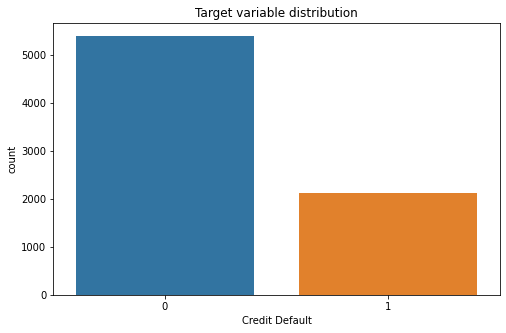

In [9]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

(0 - погашен вовремя, 1 - просрочка)

**Корреляция с базовыми признаками**

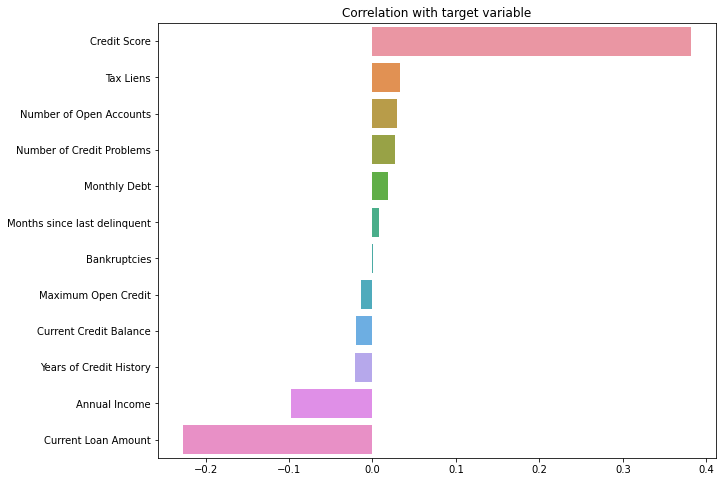

In [10]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

По графику видно, что больше всего влияют: Credit Score, Annual Income, Current Loan Amount. Но можно рассмотреть и 
    Tax Liens, Number of Open Accounts, Number of Credit Problems    

**Оценка признака "Credit Score" в разрезе целевой переменной**

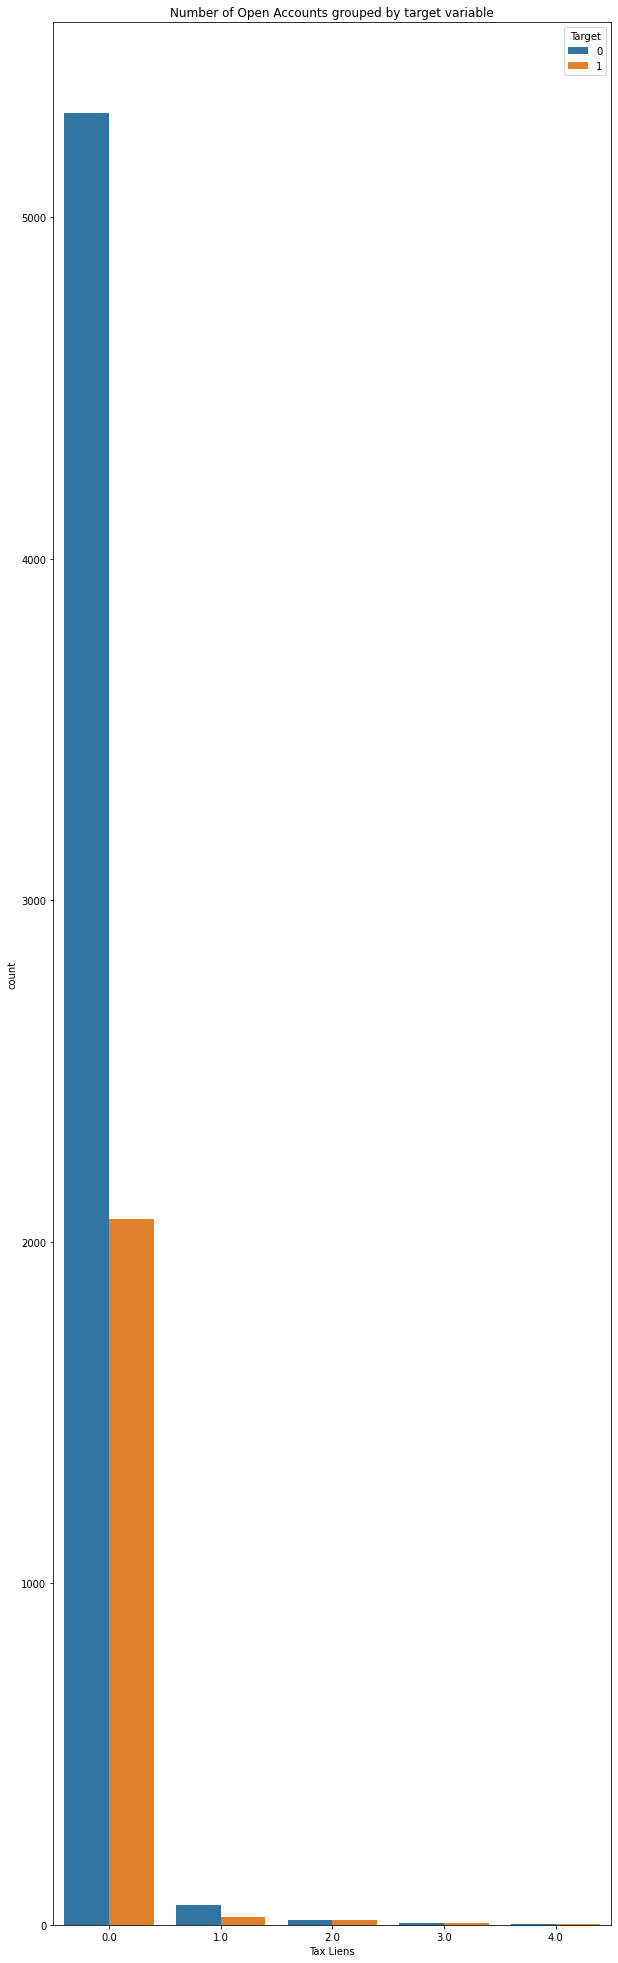

In [11]:
plt.figure(figsize=(10, 35))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=df)
plt.title('Number of Open Accounts grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения 2, 3, 4 признака "Tax Liens" имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 2, 3, 4 признака "Tax Liens" в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

*Сформируем выборку и рассчитаем наблюдаемые частоты*

In [0]:
TaxL_and_target_s = df.loc[df['Tax Liens'] > 1.0, ['ID', 'Tax Liens', 'Credit Default']]

In [13]:
table = TaxL_and_target_s.pivot_table(values='ID', index='Tax Liens', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
2.0,15,15
3.0,5,5
4.0,3,3


In [14]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

1.0

Гипотеза верна, и можно допустить, что категории 2, 3, 4 одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[df['Tax Liens'] == 3.0, 'Tax Liens'] = 2.0
df.loc[df['Tax Liens'] == 4.0, 'Tax Liens'] = 2.0

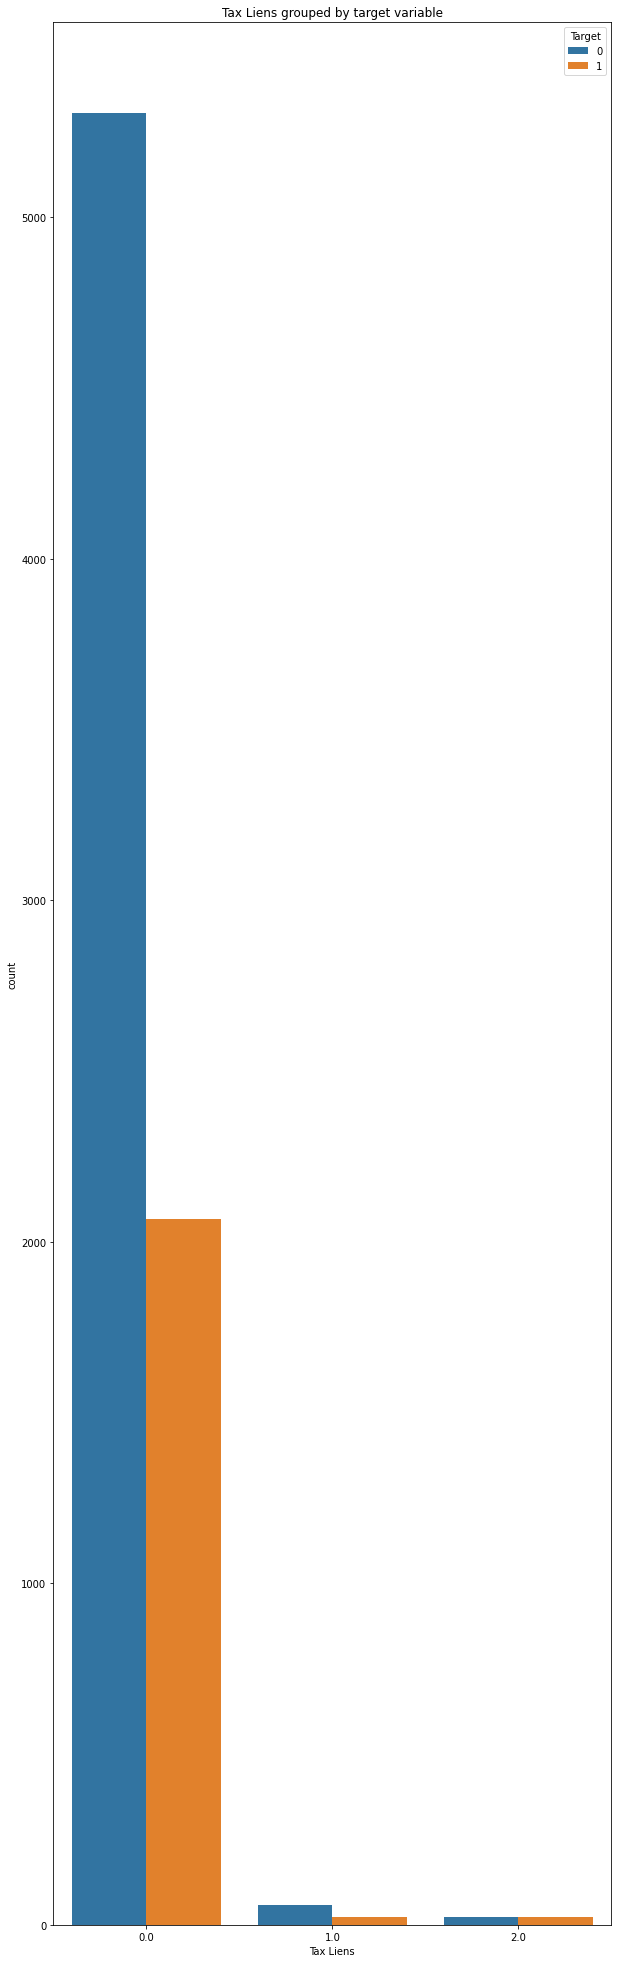

In [16]:
plt.figure(figsize=(10, 35))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=df)
plt.title('Tax Liens grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Гипотеза 2 

0 и 1 можно объединить

In [0]:
TaxL_and_target_s = df.loc[df['Tax Liens'] < 2, ['ID', 'Tax Liens', 'Credit Default']]

In [18]:
table = TaxL_and_target_s.pivot_table(values='ID', index='Tax Liens', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
0.0,5305,2066
1.0,59,24


In [19]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.8580342176294803

Гипотеза 2 верна, и можно допустить, что категории 0, 1 одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[df['Tax Liens'] == 1.0, 'Tax Liens'] = 0.0

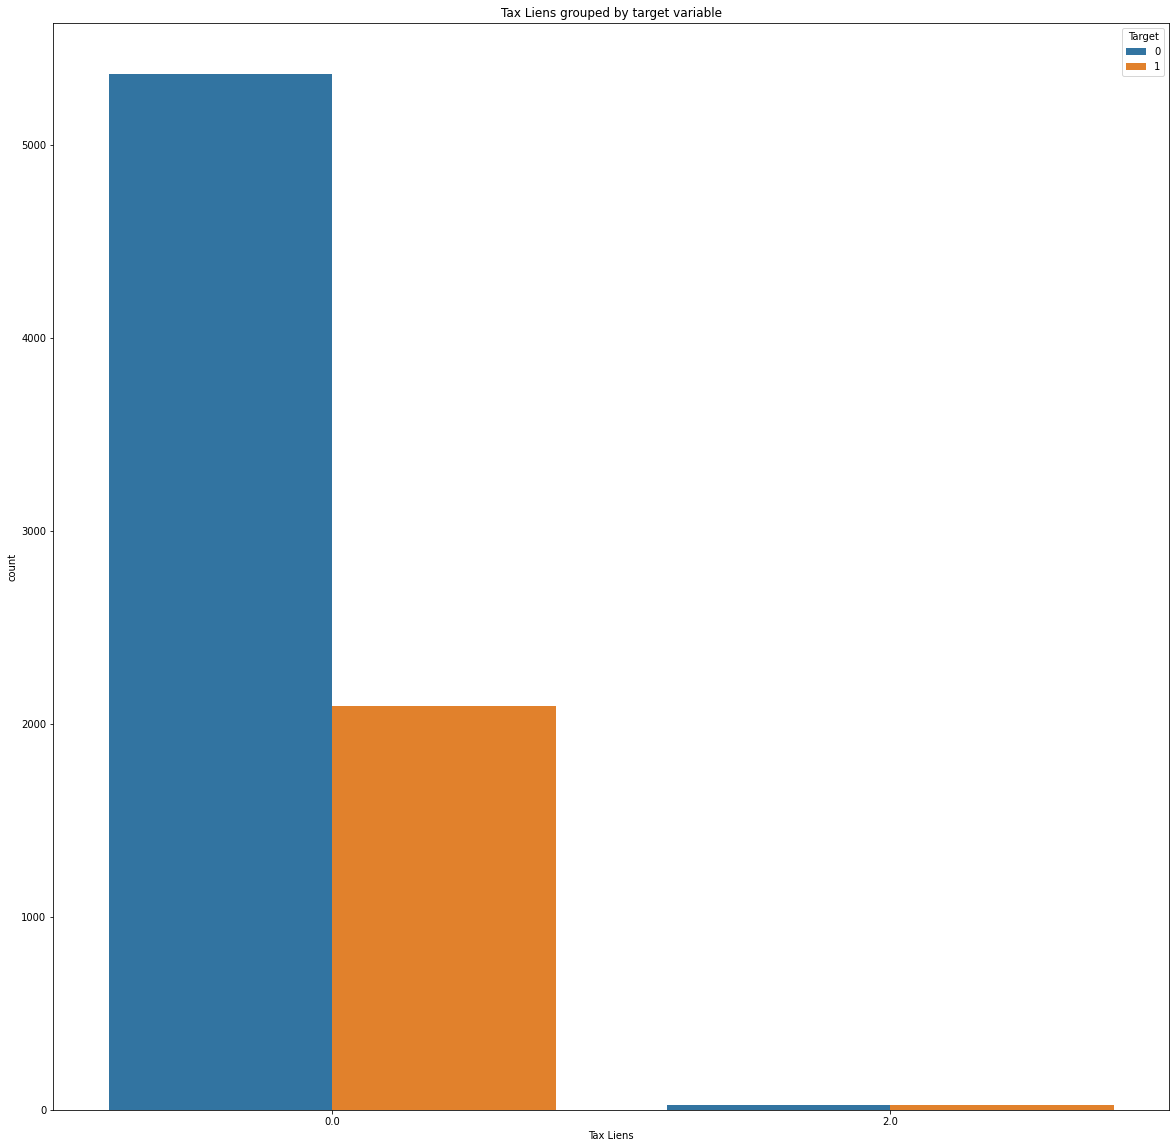

In [21]:
plt.figure(figsize=(20, 20))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=df)
plt.title('Tax Liens grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Оценка признака "Current Loan Amount" в разрезе целевой переменной**

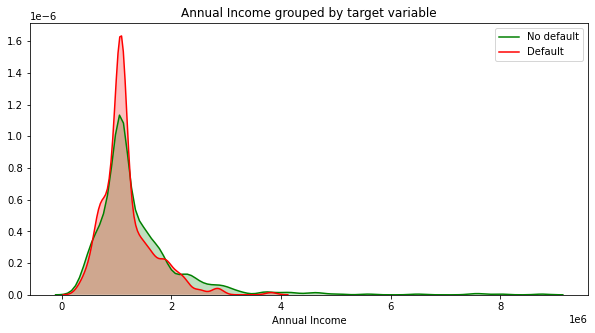

In [22]:
limit_bal_with_target_s = df[['Annual Income', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Annual Income']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Annual Income" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Annual Income" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [26]:
shapiro(limit_bal_s)

(0.6965117454528809, 5.2219205104263946e-39)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

**Матрица корреляций**

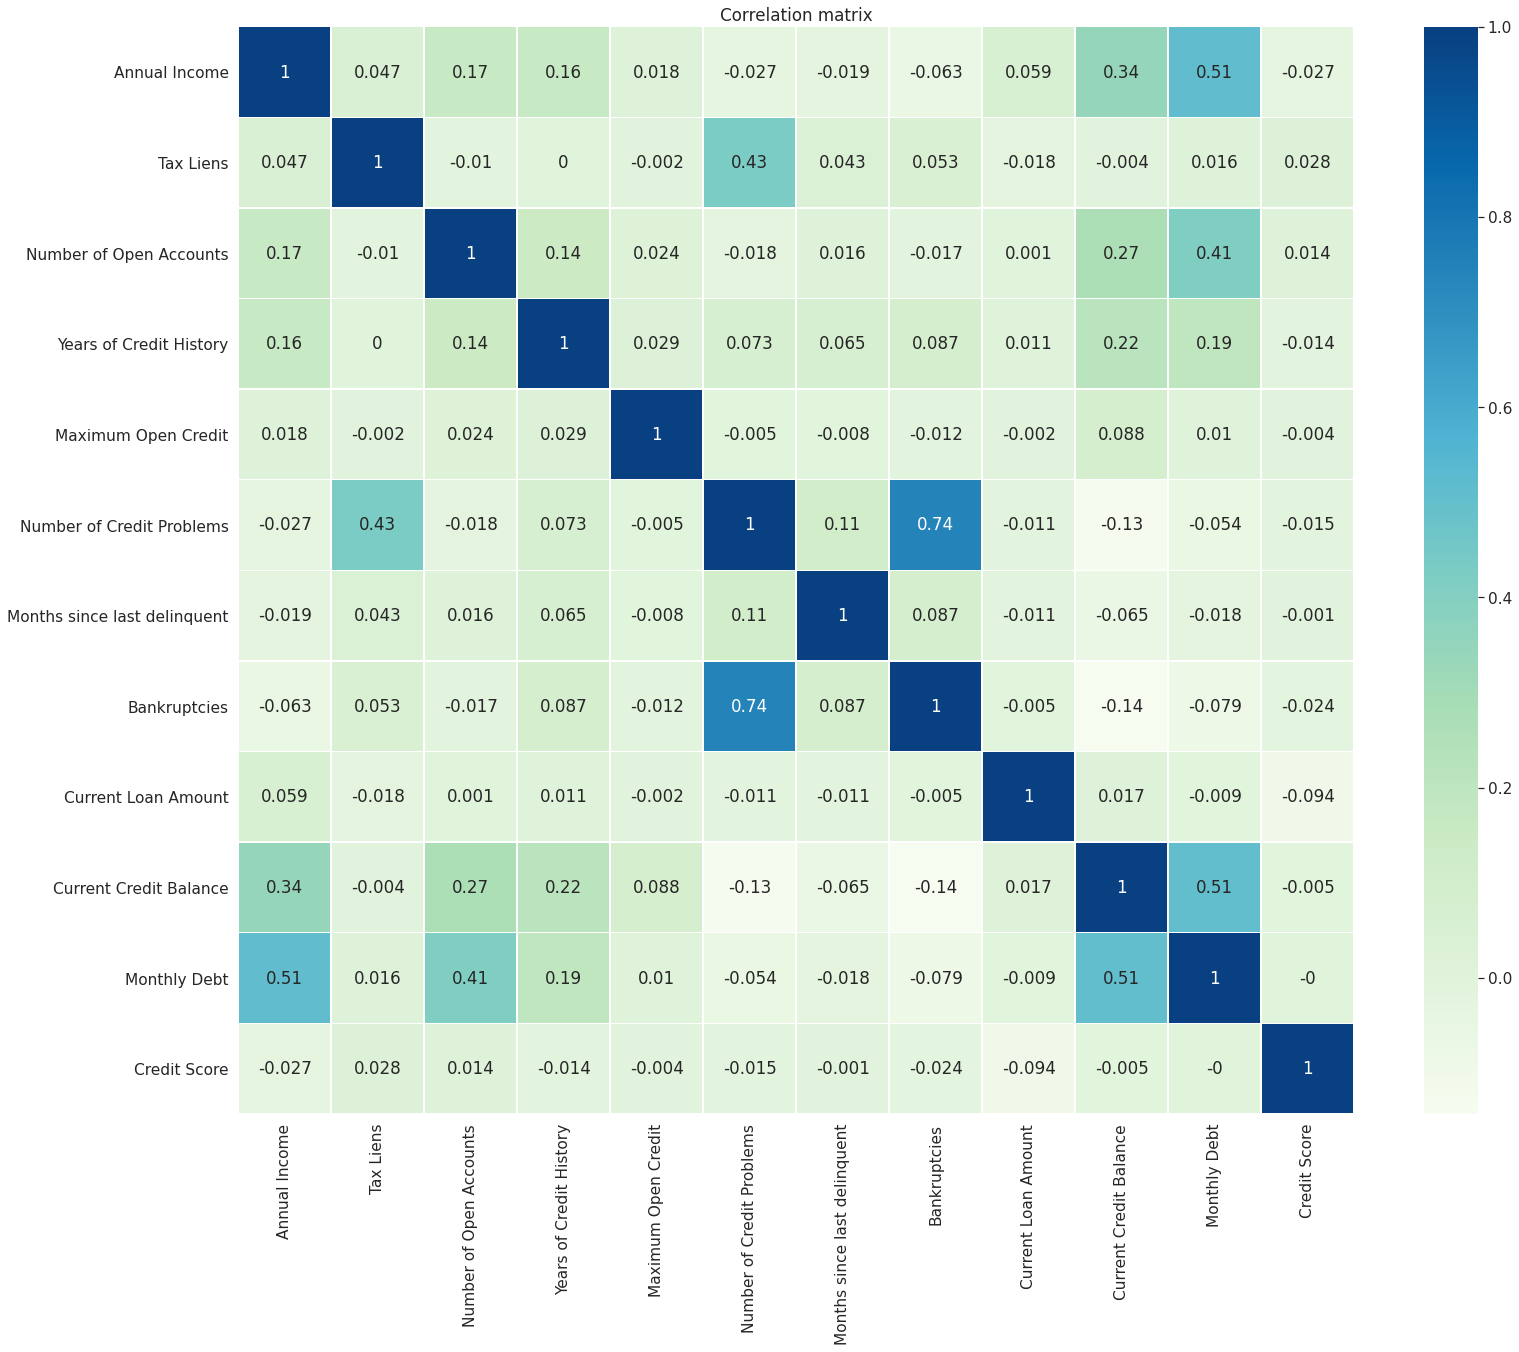

In [27]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()